In [101]:
#Benchmarking Variational Quantum State Diagonalization Algorithm

In [79]:
import pennylane as qml 
from pennylane import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# = 2
#n = 2*m
def test_prep(param):
    for i in range(2*len(param)):
        qml.Hadamard(i)
#    return [qml.expval(qml.PauliZ(i)) for i in range(2*m)]
drawer = qml.draw(test_prep)
print(drawer([0,1]))
#test_prep(m)

0: ──H─┤  
1: ──H─┤  
2: ──H─┤  
3: ──H─┤  


In [71]:
#TODO
#Make angles equal in the ith subsystem of registers 1 and 2
#param needs to be specifiable with m angles
#param = [0, 1, 2, 3]

def ansatz(param):
    for i in range(len(param)):
        qml.RZ(param[i], wires = i)
        qml.RZ(param[i], wires = i+len(param))
        qml.RX(np.pi/2, wires = i)
        qml.RX(np.pi/2, wires = i+len(param))
drawer = qml.draw(ansatz)
print(drawer([0]))

0: ──RZ(0.00)──RX(1.57)─┤  
1: ──RZ(0.00)──RX(1.57)─┤  


In [4]:
def cost_fun(param):
    for i in range(len(param)):
        qml.CNOT(wires = [i,i+len(param)])
drawer = qml.draw(cost_fun)
print(drawer([0,1]))

0: ─╭●─┤  
2: ─╰X─┤  
1: ─╭●─┤  
3: ─╰X─┤  


In [64]:
#s = 1000
#m = 2
#n = 2*m
dev = qml.device("default.qubit", wires = 2, shots = 1000)
@qml.qnode(dev, interface = "autograd")
def circuit(param):
    test_prep(param)
    ansatz(param)
    cost_fun(param)
    return qml.probs(wires = [i for i in range(len(param), 2*len(param))])

In [65]:
def VQSD(param):
    return -circuit(param)[0]

In [137]:
t = []
for i in range(1):
    t.append(0.2)
theta = np.array(t, requires_grad=True)
print(theta)

[0.2]


In [138]:
diag = [VQSD(theta)+1]
Ev0 = [eval_readout(theta)[1]]
Ev1 = [eval_readout(theta)[0]]
print(diag)
print(Ev0)
print(Ev1)

[0.44399999999999995]
[0.391]
[0.593]


In [121]:
# store the values of the circuit parameter
angle = [theta]
print(angle)
#len(angle)

[tensor([0.2], requires_grad=True)]


In [139]:
###To Do
#Figure out why the energy stays roughly constant

opt = qml.GradientDescentOptimizer(stepsize=0.2)
max_iterations = 1000
conv_tol = 1e-06
start_time = time.time()


for n in range(max_iterations):
    theta, prev_diag = opt.step_and_cost(VQSD, theta)

    diag.append(VQSD(theta)+1)
    angle.append(theta)
    Ev0.append(eval_readout(theta)[1])
    Ev1.append(eval_readout(theta)[0])

    conv = np.abs(diag[-1])

    if n % 2 == 0:
        print(f"Step = {n},  Diagonality = {diag[-1]:.8f}, Eigen_Value0 = {Ev0[-1]}, Eigen_Value1 = {Ev1[-1]}")

    if conv <= conv_tol:
        max_iterations = n
        print("\n"f"Max iterations = {n}")
        break
print("\n" f"Optimization runtime = {time.time() - start_time}s")
print("\n" f"Optimal value of the circuit parameter = {angle[-1]}")
opt_angle = angle[-1]

Step = 0,  Diagonality = 0.47200000, Eigen_Value0 = 0.379, Eigen_Value1 = 0.62
Step = 2,  Diagonality = 0.43400000, Eigen_Value0 = 0.335, Eigen_Value1 = 0.699
Step = 4,  Diagonality = 0.38800000, Eigen_Value0 = 0.281, Eigen_Value1 = 0.725
Step = 6,  Diagonality = 0.31500000, Eigen_Value0 = 0.184, Eigen_Value1 = 0.82
Step = 8,  Diagonality = 0.21600000, Eigen_Value0 = 0.113, Eigen_Value1 = 0.869
Step = 10,  Diagonality = 0.10900000, Eigen_Value0 = 0.071, Eigen_Value1 = 0.929
Step = 12,  Diagonality = 0.07200000, Eigen_Value0 = 0.053, Eigen_Value1 = 0.969
Step = 14,  Diagonality = 0.03800000, Eigen_Value0 = 0.014, Eigen_Value1 = 0.985
Step = 16,  Diagonality = 0.01700000, Eigen_Value0 = 0.005, Eigen_Value1 = 0.998
Step = 18,  Diagonality = 0.01000000, Eigen_Value0 = 0.002, Eigen_Value1 = 0.996

Max iterations = 19

Optimization runtime = 0.3034400939941406s

Optimal value of the circuit parameter = [1.4843]


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xlabel'

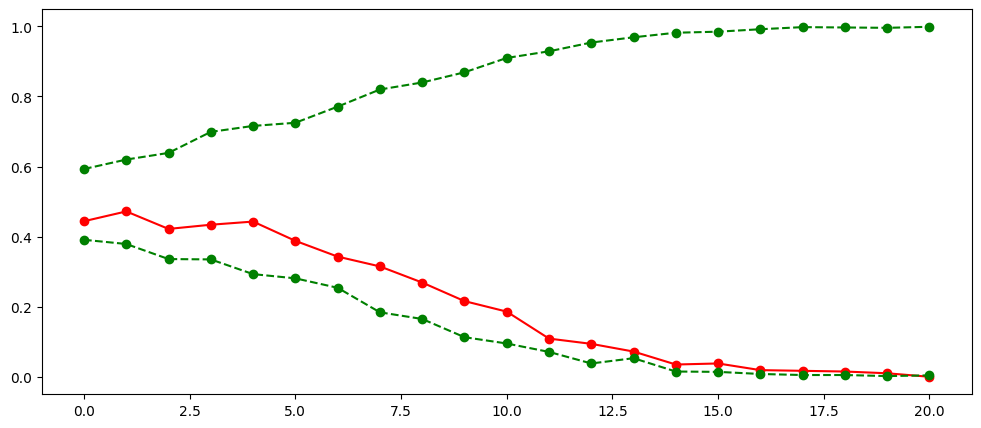

In [140]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Add energy plot on column 1

plt.plot(range(len(diag)), diag, "ro", ls = "solid")
plt.plot(range(len(diag)), Ev0, "go", ls="dashed")
plt.plot(range(len(diag)), Ev1, "go", ls="dashed")
plt.set_xlabel("Optimization step", fontsize=13)
plt.set_ylabel("Diagonality", fontsize=13)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.show()

In [70]:
opt_angle

tensor([1.5482], requires_grad=True)

In [73]:
def opt_ansatz(param):
    for i in range(len(param)):
        qml.RZ(param[i], wires = i)
        qml.RX(np.pi/2, wires = i)
drawer = qml.draw(opt_ansatz)
print(drawer([0,1]))

0: ──RZ(0.00)──RX(1.57)─┤  
1: ──RZ(1.00)──RX(1.57)─┤  


In [74]:
def opt_test_prep(param):
    for i in range(len(param)):
        qml.Hadamard(i)
drawer = qml.draw(opt_test_prep)
print(drawer([0]))

0: ──H─┤  


In [118]:
dev = qml.device("default.qubit", wires = 1, shots = 1000)
@qml.qnode(dev, interface = "autograd")
def eval_readout(param):
    opt_test_prep(param)
    opt_ansatz(param)
    return qml.probs()
#drawer = qml.draw(eval_readout)
#print(drawer([0, 1]))
eval_readout(opt_angle)[1]

0.0